In [119]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from scipy.interpolate import RegularGridInterpolator

In [120]:
dataset = np.load('generated_dataset/dataset 3 atoms (1000 images).npy')
volume = np.load('generated_dataset/reconstructed map of dataset 3 atoms (1000 images).npy')

In [121]:
def ft(obj):
    """
    Calculating the fast fourier transform of an image or volume 
    """
    return np.fft.fftn(obj)
    

In [122]:
def Slice(vol, Rotation):
    """
    Take a slice out of volume
    """

    N = volume.shape[0]
    image = np.zeros((N,N), dtype=np.complex_)
    x = np.linspace(-1,1,N)
    y = np.linspace(-1,1,N)
    z = np.linspace(-1,1,N)
    interpolating_function = RegularGridInterpolator((x,y,z), vol)

    for i in range(N):
        x = -1 + i*2/(N-1)
        for j in range(N):
            y = -1 + j*2/(N-1)
            
            vect = np.array((x,y,0))
            vect_ = Rotation.apply(vect)
            if np.max(np.abs(vect_))<=1:
                image[i,j] += interpolating_function(vect_)

    return image

In [6]:
size_image = 25 #not necessary actually
N = 32 #size grid

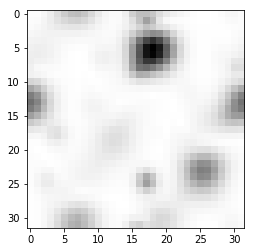

In [128]:
Rot = R.random(random_state = 6)

vol_ft = np.fft.fftn(volume)
vol_shift = np.fft.fftshift(vol_ft)
im_ft = Slice(vol_shift, Rot)
im = np.fft.ifftshift(im_ft)

plt.imshow(np.abs(np.fft.ifft2(im)), cmap = 'Greys')

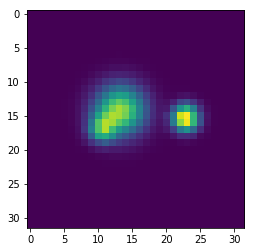

In [129]:
im_ = Slice(volume, Rot)

plt.imshow(np.absolute(im_))

In [ ]:
def backprojection(image, n):
    """
    """
    return

In [ ]:
def reconstruct(dataset, V_0, sigma_0=0, tau_0):
    return